In [1]:
from pudipflow import PUDIPFlow
import numpy as np
import h5py
import matplotlib.pyplot as plt


In [2]:
data_path = './TestData.h5'

with h5py.File(data_path, 'r') as f:
    img_gt = f['img'][:]
    segmask = f['segmask'][:]

Nv, Nt, SPE, PE, FE = img_gt.shape
SPE, PE, FE = segmask.shape

img_gt = np.transpose(img_gt, (0,1,4,3,2))
segmask = np.transpose(segmask, (2, 1, 0))
VENC  = np.array([150, 150, 150])
res  = np.array([2.5, 2.5, 2.5])
print(img_gt.shape, segmask.shape)

(4, 17, 100, 96, 19) (100, 96, 19)


In [3]:
def complex2magflow(img):
    mag = np.mean(np.abs(img), axis=0)
    flow = np.angle(img[1:]*np.conj(img[0:1]))
    return mag, flow

def wrapflow(flow, fold):
    return np.angle(np.exp(1j*flow*fold))

def magflow(flow):
    return np.sqrt(np.sum(flow**2, axis=0))

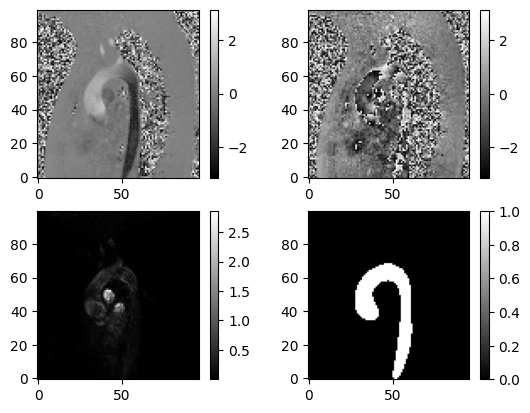

In [4]:
fold = 5 # 150 -> 50

mag_gt, flow_gt = complex2magflow(img_gt)
flow_wrapped = wrapflow(flow_gt, fold=fold)
Nv, Nt, FE, PE, SPE = flow_gt.shape

alpha = 1
pcmra = mag_gt * magflow(flow_wrapped)
weightmask = np.std(pcmra, axis=0)**alpha * pcmra
weightmask = weightmask[None]
showt = 3
showv = 0
showz = SPE // 2 + 2
plt.subplot(221)
plt.imshow(flow_gt[showv,showt, :, :, showz], cmap='gray', origin='lower')
plt.colorbar()
plt.subplot(222)
plt.imshow(flow_wrapped[showv,showt, :, :, showz], cmap='gray', origin='lower')
plt.colorbar()
plt.subplot(223)
plt.imshow(weightmask[0,3, :, :, showz], cmap='gray', origin='lower')
plt.colorbar()
plt.subplot(224)
plt.imshow(segmask[:, :, showz], cmap='gray', origin='lower')
plt.colorbar()
plt.show()

/home/ryy/miniconda3/envs/ryy/lib/python3.9/site-packages/pudipflow/core.py:579: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
  0%|          | 0/1000 [00:00<?, ?it/s]/home/ryy/miniconda3/envs/ryy/lib/python3.9/site-packages/pudipflow/core.py:613: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/home/ryy/miniconda3/envs/ryy/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
Epoch 1

[PUDIPFlow] Saved training video to: ./pudipflow_training.mp4
[PUDIPFlow] Best NRMSE: 0.0261 @ epoch 967


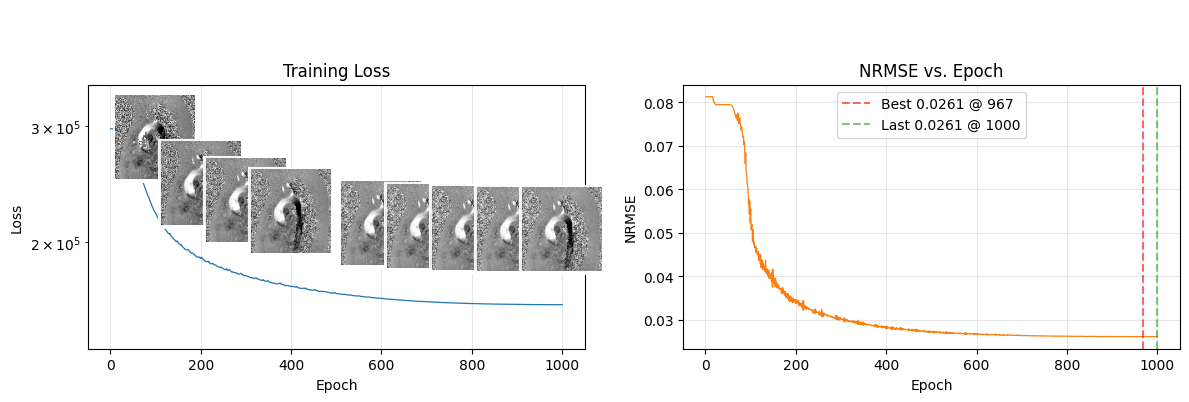

In [5]:
unwrapper = PUDIPFlow(
    venc=VENC / fold,
    level=6,
    features=128,
    input_depth=128,
    lr=1e-3,
    num_iter=1000,
    tv_weights=(1.0, 1.0, 1.0, 1.0),
    loss_type='l1',
    device="cuda:0",
    lr_scheduler="cosine",
    div_weight=0.0,
    spacing=(res[0], res[1], res[2]),
    # reshape_mode= "bt_as_batch",
    reshape_mode= "bt_as_channel",
)

result, history = unwrapper.run(
        wrapped_data=flow_wrapped,
        weightmask=np.repeat(weightmask, repeats=(Nv), axis=0),                 
        # weightmask=segmask,                 
        gt=flow_gt / np.pi * VENC[:, None,None,None,None],
        segmask=segmask,
        plot=True,
        snapshot_every=100,
        max_snapshots=10,
        snapshot_cmap="gray",
        plot_figsize=12,
        showv=showv,                      
        showt=showt,
        showz=showz,
        video_every=10,
        save_video=True,
        video_path="./pudipflow_training.mp4",
        video_fps=12,
        video_dpi=120,
        video_cmap="gray",  
    )
